In [148]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

def generate_class_0(N):
    m = [0,0]
    C = [[2, 0],[0,1]]
    return np.random.multivariate_normal(m, C, N)

def generate_class_1(N):
    m_A = [-2,1]
    C_A = [[9.0/8, 7.0/8],[7.0/8, 9.0/8]]
    m_B = [3,2]
    C_B = [[2, 1],[1, 2]]
    
    pi_1 = 1.0/3
    
    x1 = np.zeros((N,2))
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            x1[i, :] = np.random.multivariate_normal(m_A, C_A, 1)
        else:
            x1[i, :] = np.random.multivariate_normal(m_B, C_B, 1)
    return x1

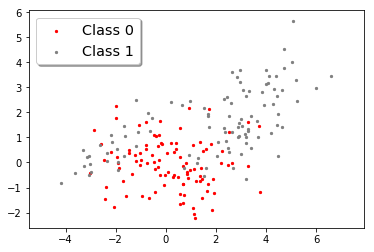

In [149]:
N = 200 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
plt.scatter(x0[:, 0],x0[:, 1], label='Class 0', c='red', s=5)

# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))
plt.scatter(x1[:, 0],x1[:, 1], label='Class 1', c='grey', s=5)

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.axis('equal')
plt.show()

In [150]:
x_train = np.concatenate([x0, x1])
y = np.append(np.zeros(int(N/2)), np.ones(int(N/2)))

# Shuffle the data
ind_perm = np.random.permutation(len(y))
x_train = x_train[ind_perm, :]
y = y[ind_perm]

# 1) SVM

In [151]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train, y)

# Classify class 0 as class -1
y[y == 0] = -1

# Use external implementation of the SMO algorithm
# http://jonchar.net/notebooks/SVM/
from SVM import SMOModel, gaussian_kernel, decision_function, train, plot_decision_boundary

# Set model parameters and initial values
C = 1.0
m = len(x_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(x_train, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

## 1.1) Plot of the decision boundaries, and display of the support vectors

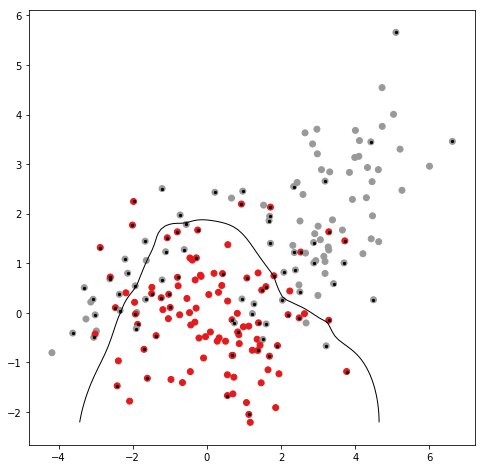

In [152]:
output = train(model)
fig, ax = plt.subplots(figsize=(8,8))
grid, ax = plot_decision_boundary(output, ax)

The plot above shows the two classes (class 0 in red, and class 1 in grey), with the decision boundary. Points that also have a black dot are support vectors.

In [153]:
# Support vectors have non-zero alphas
mask = model.alphas != 0.0
frac_support_vectors = len(model.X[:,0][mask]) / len(model.X[:,0])

print("Fraction of training data points that are support vectors:")
print(frac_support_vectors)

Fraction of training data points that are support vectors:
0.45


## 1.2) Comparison of misclassification performance between SVM and kernelized logistic regression

In [154]:
classified_points = [decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array(x), model.b) for x in model.X]
classified_points = np.array(classified_points).reshape(len(model.X[:, 0]), 1)
        
classified_points[classified_points < 0] = -1
classified_points[classified_points > 0] = 1

misclassification_error = 0
for i in range(len(y)):
    if classified_points[i] != y[i]:
        misclassification_error += 1        

print("Probability of incorrect classification:")
print(misclassification_error / len(y))

Probability of incorrect classification:
0.155


For kernelized regression we got a misclassification error probability of about ~0.15, which is very similar to that of the error probability for SVM above.

# 2) Adaboost

*AdaBoost (Freund & Schapire 1997)*

In [139]:
N = 200 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))

x_train = np.concatenate([x0, x1])
y = np.append(np.zeros(int(N/2)), np.ones(int(N/2)))

# Shuffle the data
ind_perm = np.random.permutation(len(y))
x_train = x_train[ind_perm, :]
y = y[ind_perm]

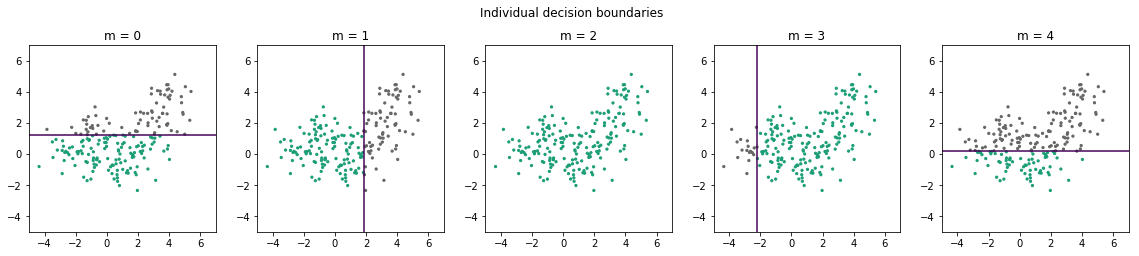

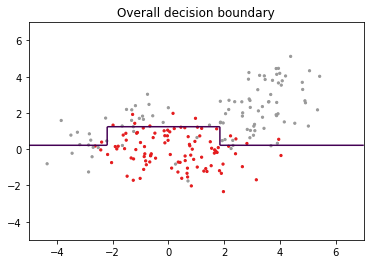

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

M = 5

# 1. Initialize the observation weights
w = np.ones(N) / N
prediction = np.zeros(N)
alpha = np.zeros(M)

C = np.zeros((N, 2))
Z_tot = np.zeros((N*N, 2))

fig, axes = plt.subplots(1, M, figsize=(16,4))
fig.tight_layout()
fig.suptitle("Individual decision boundaries")

# 2.
for m in range(M):
    # a) 
    T = DecisionTreeClassifier(max_depth=1, random_state=1)
    T.fit(x_train, y, sample_weight=w)
    prediction_m = T.predict(x_train)
    
    # b)
    I = [int(x) for x in (prediction_m != y)]
    err_m = (np.dot(w, I)) / np.sum(w)
    
    I_new = [x if x==1 else -1 for x in I] # Update weights with +1/-1
    
    # c)
    alpha_m = np.log( (1 - err_m) / float(err_m) )
    alpha[m] = alpha_m
    
    # d)
    w = np.multiply(w, np.exp([alpha_m * float(x) for x in I]))
    
    # e)
    w = w / np.sum(w)
    
    # 3. Output
    # Compute one-hot encoding
    prediction_m_onehot = np.zeros((N, 2))
    for i in range(N):
        prediction_m_onehot[i, int(prediction_m[i])] = 1
    
    C_m = alpha[m] * prediction_m_onehot
    C_m = np.argmax(C_m, axis=1).astype(np.float32)
    
    C += alpha[m] * prediction_m_onehot
    
    # Plot individual decision boundary
    X = np.linspace(-5, 7, N)
    Y = np.linspace(-5, 7, N)
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack([ X.reshape(-1), Y.reshape(-1) ]).T
    prediction_grid = T.predict(XY)
    
    prediction_grid_onehot = np.zeros((N*N, 2))
    for i in range(N*N):
        prediction_grid_onehot[i, int(prediction_grid[i])] = 1
    
    Z = alpha[m] * prediction_grid_onehot
    
    Z_tot += Z
    
    Z = np.argmax(Z, axis=1).astype(np.float32)
    Z = Z.reshape((N, N))

    if not np.all(Z):
        Z[Z == 0] = -1
        axes[m].contour(X, Y, Z, 0)
    axes[m].scatter(x_train[:, 0], x_train[:, 1], c=C_m, cmap='Dark2', s=5)
    axes[m].set_title("m = %s"%m)
    axes[m].set_aspect('equal')
    axes[m].axis([-5, 7, -5, 7])
    
C = np.argmax(C, axis=1).astype(np.float32)

# Plot overall decision boundary
Z_tot = np.argmax(Z_tot, axis=1).astype(np.float32)
Z_tot = Z_tot.reshape((N, N))
Z_tot[Z_tot == 0] = -1

plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y, cmap='Set1', s=5)
plt.contour(X, Y, Z_tot, 0)
plt.title("Overall decision boundary")
plt.show()

#print(C)
#print(y)

## 2.1) Plot of the decision boundaries

The first five individual decision boundaries are plotted above, and they are parallel to the axes, as expected.
The colors of each point is based on what the point would be classified as with the given boundary. In some cases there is no boundary line, as all points are classified as the same class.

The overall decision boundary is a combination of the individual decision boundaries: $\sum_{m=1}^5 \alpha_m \cdot G_m(\mathbf{x})$

## 2.2) Run Adaboost till the training error vanishes

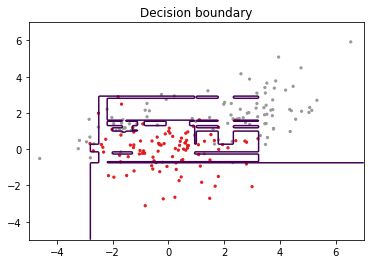

M = 1027


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

m = 1

# 1. Initialize the observation weights
w = np.ones(N) / N
prediction = np.zeros(N)

C = np.zeros((N, 2))
Z_tot = np.zeros((N*N, 2))

# 2.
while True:
    # a) 
    T = DecisionTreeClassifier(max_depth=1, random_state=1)
    T.fit(x_train, y, sample_weight=w)
    prediction_m = T.predict(x_train)
    
    # b)
    I = [int(x) for x in (prediction_m != y)]
    err_m = (np.dot(w, I)) / np.sum(w)
    
    I_new = [x if x==1 else -1 for x in I] # Update weights with +1/-1
    
    # c)
    alpha_m = np.log( (1 - err_m) / float(err_m) )
    
    # d)
    w = np.multiply(w, np.exp([alpha_m * float(x) for x in I]))
    
    # e)
    w = w / np.sum(w)
    
    # 3. Output
    # Compute one-hot encoding
    prediction_m_onehot = np.zeros((N, 2))
    for i in range(N):
        prediction_m_onehot[i, int(prediction_m[i])] = 1
    
    C_m = alpha_m * prediction_m_onehot
    C_m = np.argmax(C_m, axis=1).astype(np.float32)
    
    C += alpha_m * prediction_m_onehot
    
    # Grid output, to be used for plotting of decision boundary
    X = np.linspace(-5, 7, N)
    Y = np.linspace(-5, 7, N)
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack([ X.reshape(-1), Y.reshape(-1) ]).T
    prediction_grid = T.predict(XY)
    
    prediction_grid_onehot = np.zeros((N*N, 2))
    for i in range(N*N):
        prediction_grid_onehot[i, int(prediction_grid[i])] = 1
    
    Z_tot += alpha_m * prediction_grid_onehot
    
    if np.all(y == np.argmax(C, axis=1).astype(np.float32)):
        break
    else:
        m += 1
    
C = np.argmax(C, axis=1).astype(np.float32)

# Plot decision boundary
Z_tot = np.argmax(Z_tot, axis=1).astype(np.float32)
Z_tot = Z_tot.reshape((N, N))
Z_tot[Z_tot == 0] = -1

plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y, cmap='Set1', s=5)
plt.contour(X, Y, Z_tot, 0)
plt.title("Decision boundary")
plt.show()

print("M =", m)

Above we run Adaboost until the training error vanishes, and M varies between 400 and 2000 for N=200. There is also an extreme overfitting, as all points are taken into consideration.

## 2.3) Comparison of misclassification performance between Adaboost and kernelized SVM

In [163]:
N = 400 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))

# Split the generated data into training and test sets
ratio_training = 0.75
ratio_test = 0.25

x0_train = x0[0:math.floor(ratio_training*N/2), :]
x0_test = x0[math.floor(ratio_training*N/2):, :]

x1_train = x1[0:math.floor(ratio_training*N/2), :]
x1_test = x1[math.floor(ratio_training*N/2):, :]

# Combine the data from the two classes, and add labels
x_train = np.concatenate([x0_train, x1_train], axis=0)
x_test = np.concatenate([x0_test, x1_test], axis=0)

y = np.append(np.zeros(math.floor(ratio_training*N/2)), np.ones(math.floor(ratio_training*N/2)))
y_test = np.append(np.zeros(math.floor(ratio_test*N/2)), np.ones(math.floor(ratio_test*N/2)))

# Shuffle the generated data
ind_perm_training = np.random.permutation(len(y))
ind_perm_test = np.random.permutation(len(y_test))

x_train = x_train[ind_perm_training, :]
x_test = x_test[ind_perm_test, :]

y = y[ind_perm_training]
y_test = y_test[ind_perm_test]

In [164]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

M = 10

N_train = int(ratio_training*N) # To simplify the use of N later on
N_test = int(ratio_test*N)

# 1. Initialize the observation weights
w = np.ones(N_train) / N_train
prediction = np.zeros(N_train)
alpha = np.zeros(M)

C = np.zeros((N_train, 2))
C_test = np.zeros((N_test, 2))

# 2.
for m in range(M):
    # a) 
    T = DecisionTreeClassifier(max_depth=1, random_state=1)
    T.fit(x_train, y, sample_weight=w)
    prediction_m = T.predict(x_train)
    
    # b)
    I = [int(x) for x in (prediction_m != y)]
    err_m = (np.dot(w, I)) / np.sum(w)
    
    I_new = [x if x==1 else -1 for x in I] # Update weights with +1/-1
    
    # c)
    alpha_m = np.log( (1 - err_m) / float(err_m) )
    
    # d)
    w = np.multiply(w, np.exp([alpha_m * float(x) for x in I]))
    
    # e)
    w = w / np.sum(w)
    
    # 3. Output
    # Compute one-hot encoding
    prediction_m_onehot = np.zeros((N_train, 2))
    for i in range(N_train):
        prediction_m_onehot[i, int(prediction_m[i])] = 1
    
    C_m = alpha_m * prediction_m_onehot
    C_m = np.argmax(C_m, axis=1).astype(np.float32)
    
    C += alpha_m * prediction_m_onehot
    
    # Find prediction for test set
    prediction_test = T.predict(x_test)
    prediction_test_onehot = np.zeros((N_test, 2))
    for i in range(N_test):
        prediction_test_onehot[i, int(prediction_test[i])] = 1
    
    C_test += alpha_m * prediction_test_onehot
    
    
C = np.argmax(C, axis=1).astype(np.float32)

print(sum(C != y) / len(y))

0.17


The misclassification error for kernelized SVM and Adaboost are very similar. However, Adaboost runs must faster, and thus works better for this dataset.

# Discussion - which technique works best for this dataset?